In [1]:
%run library_utils.ipynb

import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torch import Tensor
import torch.nn as nn
from attrdict import AttrDict

tqdm.pandas()

with open('go-emotion-pool.py', 'r') as f:
    exec(f.read())
    
with open('go-emotion-gru.py', 'r') as f:
    exec(f.read())

Running with jupyter notebook


C:\Users\dumps\anaconda3\envs\go-emotions\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
arg1 = load_args('go-emotion-pool-default', 'variant_pool_mini', device=device)
arg2 = load_args('go-emotion-gru-default', 'variant_gru_mini', device=device)

device: cpu
device: cpu


In [3]:
metrics = [
    'tr_metrics.loss', 
    'tr_metrics.trigger_rate',
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
]

df_pool = get_attrs_from_checkpoints_meta(
    arg1.output_dir, 
    arg1.model_name, 
    metrics)

df_gru = get_attrs_from_checkpoints_meta(
    arg2.output_dir, 
    arg2.model_name, 
    metrics)

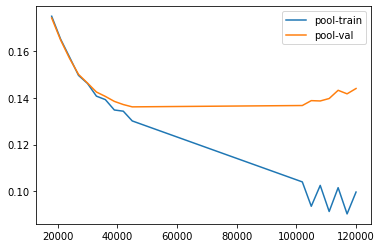

In [4]:
# plt.plot(df_gru['checkpoint_id'][3:], df_gru['tr_metrics.loss'][3:], label='gru-train')
# plt.plot(df_gru['checkpoint_id'][3:], df_gru['val_metrics.loss'][3:], label='gru-val')
plt.plot(df_pool['checkpoint_id'][3:], df_pool['tr_metrics.loss'][3:], label='pool-train')
plt.plot(df_pool['checkpoint_id'][3:], df_pool['val_metrics.loss'][3:], label='pool-val')
plt.legend()

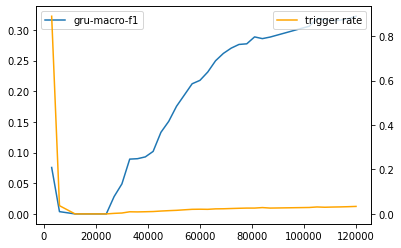

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(df_gru['checkpoint_id'], df_gru['val_metrics.macro_f1'], label='gru-macro-f1')
ax2.plot(df_gru['checkpoint_id'], df_gru['val_metrics.trigger_rate'], label='trigger rate', c='orange')

# plt.plot(df_pool['checkpoint_id'][3:], df_pool['val_metrics.macro_f1'][3:], label='pool-macro-f1')
ax1.legend()
ax2.legend()

In [6]:
ge_pool, meta_ge_pool = load_from_checkpoint(
    arg1.output_dir, 
    arg1.model_name, 
    checkpoint_id='120000', 
    load_metadata=True,
    load_model=True, 
    model_cls=GoEmotionPoolClassifer
)

In [7]:
ge_gru, meta_ge_gru = load_from_checkpoint(
    arg2.output_dir, 
    arg2.model_name, 
    checkpoint_id='102000', 
    load_metadata=True,
    load_model=True, 
    model_cls=GoEmotionGRUClassifer
)

In [8]:
def total_params(model):
    n = 0
    for p in model.parameters():
        n += p.nelement()
    return n 

In [9]:
total_params(ge_gru)

11278287

In [10]:
total_params(ge_pool)

11209087

In [11]:
tokenizer = AutoTokenizer.from_pretrained(arg2.encoder_name)
encoder = AutoModel.from_pretrained(arg2.encoder_name)

Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
test_dataset = generate_bert_dataset(
    os.path.join(
        arg2.output_dir, 
        arg2.test_dataset_path), 
    tokenizer, 
    arg2.emotions, 
    arg2.sentence_max_len, 
)

In [13]:
proba = predict_proba(ge_gru, 
                      test_dataset, 
                      batch_size=64,
                      device='cpu', 
                      back_to_cpu=True)

In [14]:
test_dataset[:]['y_true'].numpy().shape

(10748, 27)

In [15]:
results = compute_classification_metrics_per_class(
    test_dataset[:]['y_true'].numpy(), 
    proba, 
    test_dataset[:]['y_true'].mean(axis=0).numpy(), 
)

In [16]:
df = pd.DataFrame(results)
df.index = arg2.emotions
df.round(2)[['precision', 'f1', 'trigger_rate', 'auc_roc']]#.to_latex(index=True, header=True,)

,precision,f1,trigger_rate,auc_roc
admiration,0.81,0.74,0.15,0.91
amusement,0.78,0.77,0.09,0.96
anger,0.51,0.61,0.15,0.90
annoyance,0.55,0.57,0.20,0.83
approval,0.78,0.49,0.12,0.81
caring,0.49,0.53,0.09,0.92
confusion,0.49,0.58,0.14,0.90
curiosity,0.67,0.71,0.13,0.93
desire,0.33,0.42,0.09,0.92
disappointment,0.42,0.47,0.15,0.85


In [17]:
meta_ge_gru['val_metrics']

{'loss': 0.1371801824432213,
 'trigger_rate': 0.02895211730191036,
 'accuracy': 0.9544485271240178,
 'auc_roc_macro': 0.837871289543665,
 'auc_roc_micro': 0.8741698448728972,
 'macro_precision': 0.4286490464106392,
 'macro_recall': 0.2643737382300426,
 'macro_f1': 0.30586646556223784,
 'micro_precision': 0.5242713357097925,
 'micro_recall': 0.3232489737871295,
 'micro_f1': 0.3999200239928022,
 'weighted_precision': 0.48121208603835186,
 'weighted_recall': 0.3232489737871295,
 'weighted_f1': 0.3673372524541308}